Importing libraries

In [167]:
import json
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch_geometric as tg

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score

Pandas setup

In [171]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 10)  # Limit number of rows displayed
pd.set_option('display.width', 1000)  # Set max width for table
pd.set_option('display.colheader_justify', 'center')  # Center-align column headers

Reading JSON file

In [ ]:
content = None
with open('hateXplain/hate_dataset.json', 'r') as f:
    content = f.read()
print("read!")
print(content[:100])

read!
{"1179055004553900032_twitter": {"post_id": "1179055004553900032_twitter", "annotators": [{"label": 


In [145]:
content = content.replace("'", '"')
print("replaced!")
print(content[:100])

replaced!
{"1179055004553900032_twitter": {"post_id": "1179055004553900032_twitter", "annotators": [{"label": 


In [146]:
print(content[480:500])

witter": {"post_id":


In [147]:
try:
    data = json.loads(content)
except json.JSONDecodeError as e:
    print(f"Error: {e}")

In [148]:
for i, (key, value) in enumerate(data.items()):
    if i < 5:
        print(f"{key}: {value}")
    else:
        break

1179055004553900032_twitter: {'post_id': '1179055004553900032_twitter', 'annotators': [{'label': 'normal', 'annotator_id': 1, 'target': ['None']}, {'label': 'normal', 'annotator_id': 2, 'target': ['None']}, {'label': 'normal', 'annotator_id': 3, 'target': ['None']}], 'rationales': [], 'post_tokens': ['i', 'dont', 'think', 'im', 'getting', 'my', 'baby', 'them', 'white', '9', 'he', 'has', 'two', 'white', 'j', 'and', 'nikes', 'not', 'even', 'touched']}
1179063826874032128_twitter: {'post_id': '1179063826874032128_twitter', 'annotators': [{'label': 'normal', 'annotator_id': 1, 'target': ['None']}, {'label': 'normal', 'annotator_id': 2, 'target': ['None']}, {'label': 'normal', 'annotator_id': 3, 'target': ['None']}], 'rationales': [], 'post_tokens': ['we', 'cannot', 'continue', 'calling', 'ourselves', 'feminists', 'if', 'the', 'rights', 'of', 'all', 'womxn', 'arent', 'addressed', 'yes', 'to', 'a', 'sexual', 'offences', 'public', 'list', 'but', 'will', 'a', 'trans', 'lesbian', 'bisexual', 'a

Exploring the columns

In [149]:
# Collect and display all the inner ids
column_names = []
for outer_key, inner_dict in data.items():
    if isinstance(inner_dict, dict):  # Ensure the value is a dictionary
        keys = inner_dict.keys()
        for key in keys:
            if key not in column_names:
                column_names.append(key)

print("Inner IDs:", column_names)

Inner IDs: ['post_id', 'annotators', 'rationales', 'post_tokens']


Gathering the full vocabulary (word set)

In [150]:
vocab = set() # Use a set to avoid duplicates

# Collect all the words from all the posts in the dataset
for twitter_id in data:
    vocab |= set(data[twitter_id]['post_tokens'])
print("Vocab size:", len(vocab))
print(type(vocab))
print(list(vocab)[:100])

Vocab size: 28838
<class 'set'>
['jet', 'fin', 'centralized', 'shovels', 'lockherup', 'shitholes', 'fallow', 'jinnah', 'sawaal', 'muscum', 'meenie', 'arrangement', 'hairstyle', 'wide', 'milestone', 'transforming', 'capsicum', 'blackhead', 'applied', 'roach', 'thurgood', 'abdully', 'chooses', 'monster', 'stalk', 'quoting', 'abetting', 'hotness', 'sorcery', 'dumbfucks', 'thighs', 'grubby', 'pulak', 'jamal', 'trs', 'taekooker', 'kobo', 'blacker', 'id', 'mcdonalds', 'harassers', 'unicode', 'sultan', 'conceded', 'wbk', 'basements', '💞', 'armbands', 'hah', 'whoohoo', 'payed', 'mmg', 'bhagya', 'niqab', '\u202a', 'lasting', 'mbc3', 'dream', 'acclimate', 'cacophany', 'rss', 'kurdistan', 'diesel', 'patty', 'ire', 'serapis', 'privileges', 'naseeruddinshah', 'whatsapp', 'weathermen', 'degrees', 'crackheads', 'sending', 'outdoor', 'narratives', 'maltese', 'manned', 'attic', 'pregger', 'unrest', 'choke', 'fibre', 'downside', 'vonn', 'gifs', 'junior', 'reminding', 'laila', 'lured', 'pic', 'marilou', 

Checking if each row has all of the columns

In [151]:
ids = []
for i, (key, value) in enumerate(data.items()):
    keys = inner_dict.keys()
    for column in column_names:
        if column not in keys:
            ids.append(i)
            break
print(ids)

[]


In [152]:
def add_bar_labels_grouped(ax, x, counts, width, fontsize=10, color='black'):
    for group_idx, x_pos in enumerate(x):
        for offset_idx, value in enumerate(counts[group_idx]):
            # Calculate x position for each bar in the group
            x_bar = x_pos + offset_idx * width
            ax.text(x_bar, value + 0.02 * max([max(group) for group in counts]), str(value), 
                    ha='center', va='bottom', fontsize=fontsize, color=color)


In [153]:
def add_bar_labels_grouped(ax, x, counts, width, fontsize=10, color='black'):
    for group_idx, x_pos in enumerate(x):
        for offset_idx, value in enumerate(counts[group_idx]):
            # Calculate x position for each bar in the group
            x_bar = x_pos + offset_idx * width
            ax.text(x_bar, value + 0.02 * max(counts[group_idx]), str(value), 
                    ha='center', va='bottom', fontsize=fontsize, color=color)


Exploring annotator labels and targets of potential offensive comments

In [154]:
target_counts = defaultdict(int)
label_counts = defaultdict(int)

for tweet_id, tweet_data in data.items():
    for column_name, column_value in tweet_data.items():
        if column_name == 'annotators':
            for annotator in column_value:
                label_counts[annotator['label']] += 1
                for target in annotator['target']:
                    target_counts[target] += 1

print("Target counts:\n")
for target, target_count in target_counts.items():
    print(f"{target}: {target_count}")
print("\n- - - - - - -\nLabel counts:\n")
for label, label_count in label_counts.items():
    print(f"{label}: {label_count}")


Target counts:

None: 21314
African: 10015
Asian: 1350
Caucasian: 2359
Women: 6126
Jewish: 5961
Homosexual: 5617
Islam: 6686
Other: 4708
Hispanic: 1299
Refugee: 3100
Men: 1758
Arab: 2907
Disability: 221
Minority: 188
Nonreligious: 87
Indigenous: 83
Indian: 81
Economic: 90
Christian: 270
Heterosexual: 141
Bisexual: 8
Hindu: 89
Buddhism: 12
Asexual: 5

- - - - - - -
Label counts:

normal: 24449
hatespeech: 18070
offensive: 17925


Visualisation

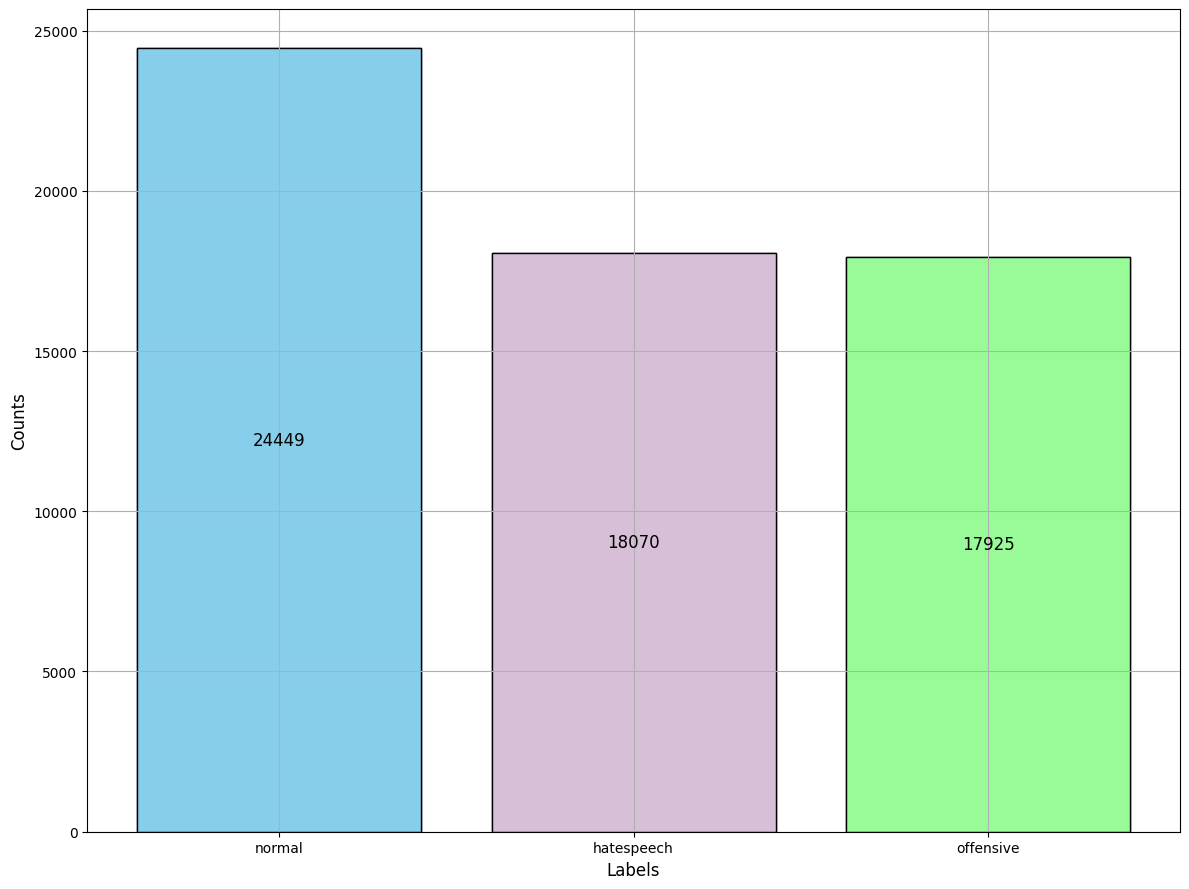

In [155]:
keys = list(label_counts.keys())
values = list(label_counts.values())

fig, ax = plt.subplots(figsize=(12, 9))

colors = ['skyblue', 'thistle', 'palegreen', 'goldenrod', 'lightcoral']

ax.bar(keys, values, color='skyblue', edgecolor='black')

add_bar_labels(ax, values, fontsize=12)
plt.bar(keys, values, color=colors, edgecolor='black')

ax.set_xlabel("Labels", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)

ax.grid()
plt.tight_layout()
plt.show()

Analysing how many times each target group was mentioned with each type of interaction

In [156]:
target_label_counts  = defaultdict(lambda: defaultdict(int))

for tweet_id, tweet_data in data.items():
    for column_name, column_value in tweet_data.items():
        if column_name == 'annotators':
            for annotator in column_value:
                label = annotator['label']
                for target in annotator['target']:
                    target_label_counts[target][label] += 1

target_label_counts = {target: dict(counts) for target, counts in target_label_counts.items()}

print("Target label counts:\n")
for target, label_counts in target_label_counts.items():
    print(f"{target}: {label_counts}")

Target label counts:

None: {'normal': 18484, 'offensive': 2549, 'hatespeech': 281}
African: {'normal': 681, 'hatespeech': 6557, 'offensive': 2777}
Asian: {'hatespeech': 600, 'offensive': 512, 'normal': 238}
Caucasian: {'hatespeech': 671, 'offensive': 1117, 'normal': 571}
Women: {'hatespeech': 1762, 'offensive': 3168, 'normal': 1196}
Jewish: {'hatespeech': 4046, 'offensive': 1515, 'normal': 400}
Homosexual: {'offensive': 2506, 'hatespeech': 2230, 'normal': 881}
Islam: {'hatespeech': 3604, 'normal': 838, 'offensive': 2244}
Other: {'hatespeech': 1353, 'normal': 915, 'offensive': 2440}
Hispanic: {'offensive': 419, 'hatespeech': 783, 'normal': 97}
Refugee: {'hatespeech': 937, 'offensive': 1289, 'normal': 874}
Men: {'hatespeech': 527, 'offensive': 631, 'normal': 600}
Arab: {'hatespeech': 1823, 'normal': 196, 'offensive': 888}
Disability: {'hatespeech': 72, 'offensive': 149}
Minority: {'hatespeech': 140, 'offensive': 48}
Nonreligious: {'hatespeech': 65, 'offensive': 22}
Indigenous: {'offensi

Visualisation

{'normal': 18484, 'offensive': 2549, 'hatespeech': 281}


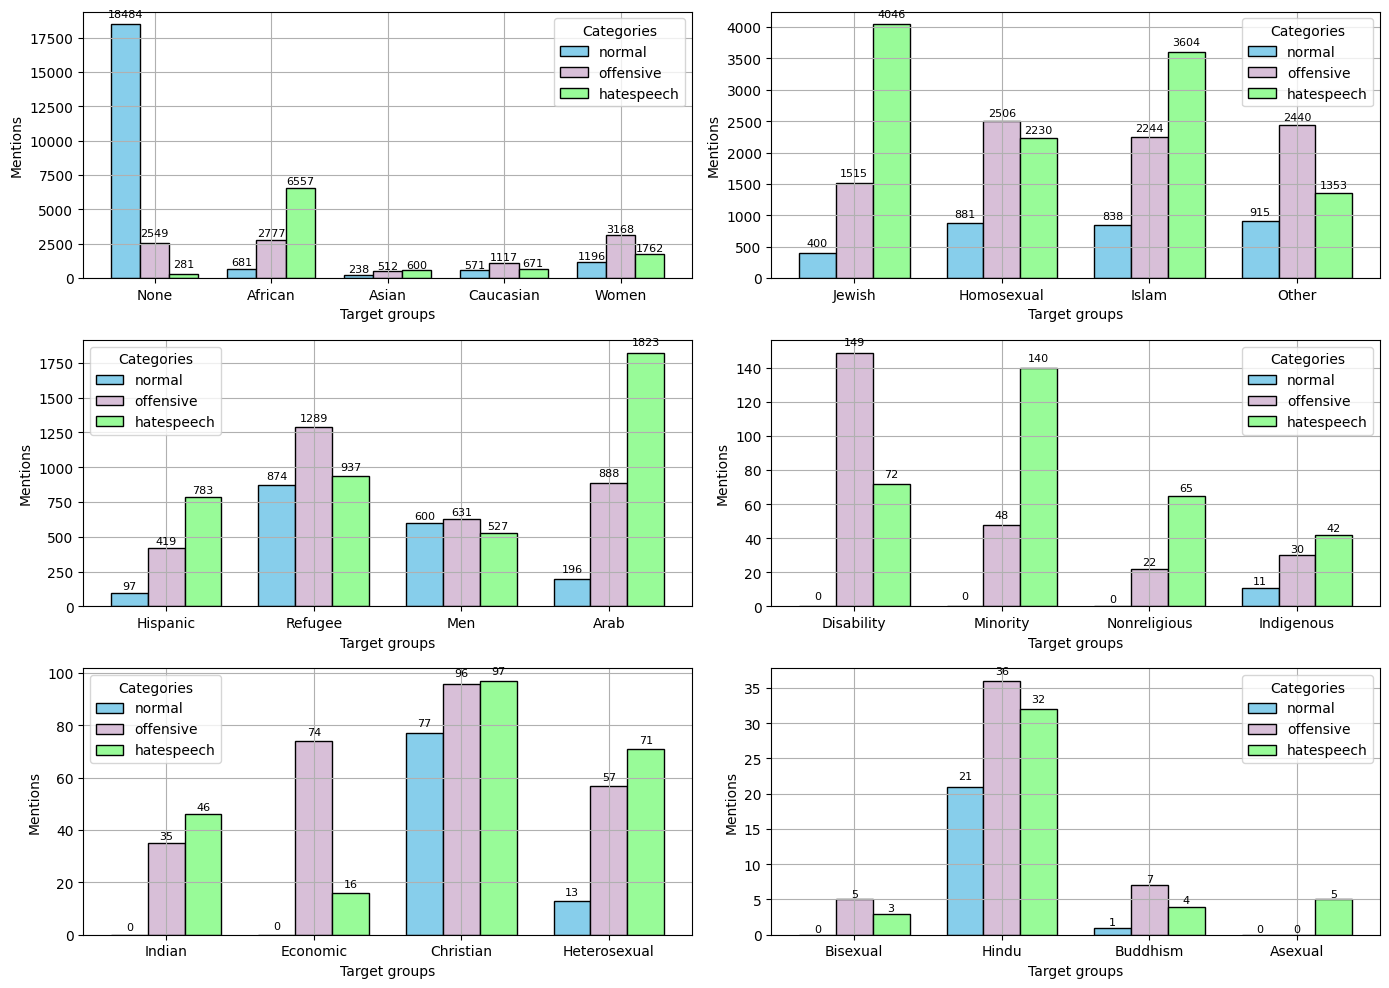

In [157]:
keys = list(target_label_counts.keys())
values = list(target_label_counts.values())
categories = ["normal", "offensive", "hatespeech"]

# Ensure all categories are present in each target group
for key, counts in target_label_counts.items():
    for category in categories:
        counts.setdefault(category, 0) 

key_bundles = np.array_split(keys, 6)
value_bundles = np.array_split(values, 6)

colors = ['skyblue', 'thistle', 'palegreen', 'goldenrod', 'lightcoral']
fig, ax = plt.subplots(3, 2, figsize=(14, 10))

print(values[0])

for idx, (key_bundle, value_bundle) in enumerate(zip(key_bundles, value_bundles)):
    row = idx // 2
    col = idx % 2

    # Prepare x positions and width for grouped bars
    x = np.arange(len(key_bundle))  # Bar positions for the target groups
    width = 0.25  # Width of each bar

    # Extract counts for each category
    grouped_counts = [[label_counts[category] for category in categories] for label_counts in value_bundle]

    # Plot each category as separate bars
    for i, category in enumerate(categories):
        counts = [label_counts[category] for label_counts in value_bundle]  # Extract counts for the current category
        ax[row, col].bar(x + i * width, counts, width, label=category, color=colors[i], edgecolor='black')

    # Add bar labels for the grouped bars
    add_bar_labels_grouped(ax[row, col], x, grouped_counts, width, fontsize=8)

    # Format the subplot
    ax[row, col].set_xticks(x + width)  # Align group labels with bar centers
    ax[row, col].set_xticklabels(key_bundle)
    ax[row, col].set_xlabel("Target groups", fontsize=10)
    ax[row, col].set_ylabel("Mentions", fontsize=10)
    ax[row, col].legend(title="Categories")
    ax[row, col].grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Convert JSON-type data into a pandas dataframe for the future

In [168]:
def convert_to_tabular(data):
    records = []
    for record in data:
        post_id = record['post_id']
        
        # Count labels
        label_counts = Counter([annotator['label'] for annotator in record['annotators']])
        
        # Primary label (majority vote)
        primary_label = label_counts.most_common(1)[0][0] if label_counts else None
        
        # Unique targets
        targets = set()
        for annotator in record['annotators']:
            targets.update(annotator['target'])
        targets = ", ".join(targets)  # Join targets into a string
        
        # Has rationales
        has_rationales = int(len(record['rationales']) > 0)
        
        # Concatenate post tokens
        post_text = " ".join(record['post_tokens'])
        
        # Create a flattened row
        flattened_row = {
            'post_id': post_id,
            'normal': label_counts.get('normal', 0),
            'offensive': label_counts.get('offensive', 0),
            'hate_speech': label_counts.get('hate speech', 0),
            'primary_label': primary_label,
            'targets': targets,
            'has_rationales': has_rationales,
            'post_text': post_text
        }
        records.append(flattened_row)
    
    # Convert to DataFrame
    return pd.DataFrame(records)

In [ ]:
json_type_data = data.values()
json_type_data = list(json_type_data)

df = convert_to_tabular(json_type_data)
print(df.head())

            post_id             normal  offensive  hate_speech primary_label      targets       has_rationales                     post_text                     
0  1179055004553900032_twitter     3        0           0            normal               None         0        i dont think im getting my baby them white 9 h...
1  1179063826874032128_twitter     3        0           0            normal               None         0        we cannot continue calling ourselves feminists...
2  1178793830532956161_twitter     2        0           0            normal      African, None         0                            nawt yall niggers ignoring me
3  1179088797964763136_twitter     0        1           0        hatespeech              Asian         1        <user> i am bit confused coz chinese ppl can n...
4  1179085312976445440_twitter     0        1           0        hatespeech   Women, Caucasian         1        this bitch in whataburger eating a burger with...
